In [148]:
import gpxpy
import gpxpy.gpx
import geopy.distance as distance
import math
import statistics
import numpy as np
from scipy.interpolate import CubicSpline, barycentric_interpolate, interp1d
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [2]:
gpx_file = open("gpx/strecke01.gpx")
gpx = gpxpy.parse(gpx_file)


In [49]:
tol = 1
for i in range(14):
    gpx_file = open(f"gpx/strecke{i+1:02d}.gpx")
    gpx = gpxpy.parse(gpx_file)
    lengths = []
    grads = []

    for track in gpx.tracks:
        for segment in track.segments:
            pts = list(segment.points)
            for p0, p1 in zip(pts[:-1], pts[1:]):
                dist_2d = distance.distance((p0.latitude, p0.longitude), (p1.latitude, p1.longitude)).m
                dist_3d = math.sqrt(((p1.elevation - p0.elevation))**2 + dist_2d**2)
                if dist_2d > tol:
                    grads.append((p1.elevation - p0.elevation) / dist_2d)
                    if grads[-1] > .50:
                        print(p0, p1, dist_2d)
                    lengths.append(dist_3d)

    print(f"Strecke", i+1, f"{sum(lengths)/1000 - .1:.2f} km", f"{statistics.median(grads):.02%}")


Strecke 1 3.60 km 1.20%
Strecke 2 13.76 km 0.00%
Strecke 3 5.84 km 7.26%
Strecke 4 5.88 km -1.68%
[trkpt:47.355190254282206,8.462160228285939@530.0@None] [trkpt:47.355200147256255,8.462160418275744@530.7999877929688@None] 1.0999724221246248
[trkpt:47.37989047775045,8.469360672403127@501.0999755859375@None] [trkpt:47.37987978057936,8.469349871389568@501.8999938964844@None] 1.4421122544855
Strecke 5 14.02 km -2.18%
Strecke 6 10.38 km 0.00%
Strecke 7 4.41 km -0.50%
Strecke 8 6.34 km 2.00%
Strecke 9 11.16 km 0.00%
Strecke 10 8.49 km -1.19%
Strecke 11 12.82 km 0.00%
Strecke 12 6.17 km -1.00%
Strecke 13 4.79 km 0.00%
[trkpt:47.39830036228523,8.552740157116205@498.3999938964844@None] [trkpt:47.398279678076506,8.552739724516869@499.59999084472656@None] 2.299873371828313
Strecke 14 5.54 km -2.86%


We now correct the distances using an approximation of the [GAP](https://medium.com/strava-engineering/an-improved-gap-model-8b07ae8886c3) Model.

[[-32.     1.6 ]
 [-28.     1.45]
 [-24.     1.24]
 [-20.5    1.1 ]
 [-17.5    1.  ]
 [-10.     0.9 ]
 [  0.     1.  ]
 [  1.     1.02]
 [  2.     1.05]
 [  3.     1.1 ]
 [  4.     1.15]
 [  5.     1.2 ]
 [ 10.     1.5 ]
 [ 20.     2.3 ]
 [ 30.     3.2 ]]


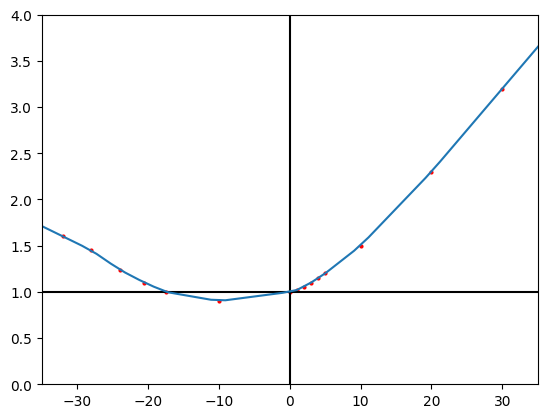

In [153]:
obs_pts = np.array([
    (0, 1),
    (-10, .9),
    (-17.5, 1),
    (-20.5, 1.1),
    (-24, 1.24),
    (-28, 1.45),
    (-32, 1.6),
    (1, 1.02),
    (2, 1.05),
    (3, 1.1),
    (4, 1.15),
    (5, 1.2),
    (10, 1.5),
    (20, 2.3),
    (30, 3.2)
])

obs_pts = obs_pts[obs_pts[:, 0].argsort()]
print(obs_pts)

cs = interp1d(obs_pts[:, 0], obs_pts[:, 1], fill_value="extrapolate")
x = np.linspace(-100,100, 100)
# plt.plot(obs_pts[:, 0], obs_pts[:,1])
plt.vlines(0, -100, 100, "black")
plt.hlines(1, -100, 100, "black")
plt.scatter(obs_pts[:, 0], obs_pts[:, 1], color="red", s=4)
plt.plot(x, cs(x))
plt.xlim([-35, 35])
plt.ylim([0, 4])
plt.show()

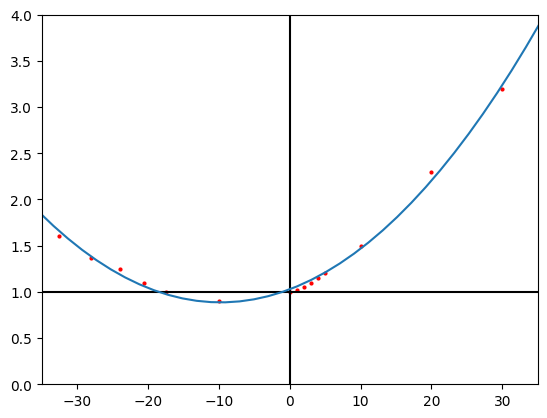

In [145]:
obs_pts = np.array([
    (0, 1),
    (-10, .9),
    (-17.5, 1),
    (-20.5, 1.1),
    (-24, 1.25),
    (-28, 1.37),
    (-32.5, 1.6),
    (1, 1.02),
    (2, 1.05),
    (3, 1.1),
    (4, 1.15),
    (5, 1.2),
    (10, 1.5),
    (20, 2.3),
    (30, 3.2)
])

obs_pts = obs_pts[obs_pts[:, 0].argsort()]
r = Ridge()
sq_comp = lambda x: np.stack((x, x**2)).T
r.fit(sq_comp(obs_pts[:, 0]), obs_pts[:, 1].reshape(-1, 1))
x = np.linspace(-100,100, 100)
# plt.plot(obs_pts[:, 0], obs_pts[:,1])
plt.vlines(0, -100, 100, "black")
plt.hlines(1, -100, 100, "black")
plt.plot(x, r.predict(sq_comp(x)))
plt.scatter(obs_pts[:, 0], obs_pts[:, 1], color="red", s=4)
plt.xlim([-35, 35])
plt.ylim([0, 4])
plt.show()